<a href="https://colab.research.google.com/github/tcardwell/Predicting-Distracted-Drivers/blob/master/2_Visualize_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Distracted Drivers
## Tracy Cardwell
### Visualize Data Augmentation


### Introduction
According to the CDC, every day in America about 9 people are killed and more than 1000 are injured in crashes that involve a distracted driver.

Distractions include:

* visual: taking your eyes off the road;
* manual: taking your hands off the steering wheel; and
* cognitive: taking your mind off driving.  

This project aims to identify distractions from dashboard camera images taken during driving. The distractions captured in the images are:

* texting with right hand,
* holding phone in right hand,
* texting with left hand,
* holding phone in left hand,
* operating the radio,
* drinking,
* reaching behind,
* fixing hair or applying makeup, and
* talking to a passenger. There are also images of safe driving.  

Note: these images were created by State Farm Insurance company in a controlled environment - a truck dragging a car around on the streets - so these "drivers" weren't really driving.

The goal of this exercise is to determine whether dashboard cameras can automatically detect distracted drivers and perhaps provide a method to reduce distracted driver accidents, injuries and deaths.



In [0]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [0]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Copy the data from Google Drive and unzip.  

In [0]:
project_path = "/content/drive/My Drive/Capstone 2/"
filename = "processed.zip"
zip_path = os.path.normpath(os.path.join(project_path, filename))
print(zip_path)
!cp "{zip_path}" .
!unzip -q {filename}
!rm {filename}

/content/drive/My Drive/Capstone 2/processed.zip


In [0]:
# Get environment variables and set path variables. 

train_path = "proc/imgs/train"
test_path = "proc/imgs/test"
valid_path = "proc/imgs/valid"

In [0]:
# Build list of class names from image subdirectory names. 

classes = []
for root,dirs,_ in os.walk(train_path):
    for d in dirs:
        classes.append(d)
classes.sort()
num_classes = len(classes)
classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [0]:
# plots images with labels (adapted from fastai)
def plot_imgs(imgs, figsize=(12,6), rows=1, titles=None, color_mode='rgb'):
    """
    Plot Images with Labels from ImageDataGenerator. 
    """
    cmap = None
    class_label_dict = {0: 'Normal driving', 
                        1: 'Texting - right', 
                        2: 'Talking on phone - right', 
                        3: 'Texting - left', 
                        4: 'Talking on phone - left', 
                        5: 'Operating the radio', 
                        6: 'Drinking', 
                        7: 'Reaching behind', 
                        8: 'Hair and makeup', 
                        9: 'Talking to passenger'}
# Check for grayscale image and reshape imgs for imshow() if needed. 
    if (color_mode == 'grayscale'):
        cmap = 'gray'
        if (imgs.shape[-1] == 1): 
            imgs = imgs.reshape((imgs.shape[0],imgs.shape[1],imgs.shape[2]))

    fig = plt.figure(figsize=figsize)
    cols = len(imgs)//rows if len(imgs) % rows == 0 else len(imgs)//rows + 1
    for i in range(len(imgs)):
        sp = fig.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            class_label = np.argmax(titles[i])
            sp.set_title(class_label_dict[class_label], fontsize=16)
        if (cmap == 'gray'):
            plt.imshow(imgs[i], cmap=cmap)
        else:
            plt.imshow(imgs[i])
    plt.show()

def stats_imgs(imgs, titles=None):
    """
    Print statistics of images from ImageDataGenerator.
    """

    for i in range(len(imgs)):
        min_im = imgs[i].min()
        max_im = imgs[i].max()
        mean_im = np.mean(imgs[i])
        std_im = np.std(imgs[i])
        print("Image No: {}:  Min: {:0.3f}, Max: {:0.3f}, Mean: {:0.3f}, Std: {:0.3f}".format(i, min_im, max_im, mean_im, std_im))

    return

In [0]:
def create_datagen_flows(train_gen, val_gen, train_path, val_path, test_path, img_height, img_width, color_mode, classes, batch_size):
    """
    Create train, validation, and test flow_from_directory generators. 

    Input:    train_gen:  ImageDataGenerator object for training images
              val_gen:    ImageDataGenerator object for validation/test images
              train_path: top of directory tree for training images
              val_path:   top of directory tree for validation images
              test_path:  top of directory tree for test images
              img_height: image height, pixels
              img_width:  image width, pixels
              color_mode: tf.keras color_mode
              classes:    list of class labels corresponding to subdirectory names
              batch_size: batch size to generate on next()
    """

    train_batches = train_gen.flow_from_directory(
                                                  directory=train_path, 
                                                  target_size=(img_height, img_width), 
                                                  color_mode = color_mode,
                                                  classes=classes, 
                                                  batch_size=batch_size, 
                                                  shuffle=True
                                                  )
    val_batches = val_gen.flow_from_directory(
                                              directory=val_path, 
                                              target_size=(img_height, img_width), 
                                              color_mode = color_mode,
                                              classes=classes, 
                                              batch_size=batch_size, 
                                              shuffle=True
                                              )
    test_batches = val_gen.flow_from_directory(
                                               directory=test_path, 
                                               target_size=(img_height, img_width), 
                                               color_mode = color_mode,
                                               classes=classes, 
                                               batch_size=batch_size, 
                                               shuffle=False
                                               )
    return(train_batches, val_batches, test_batches)

In [0]:
def create_datagen_flow_array(datagen, x, y, batch_size, shuffle=True):
    """
    Create a flow generator. 

    Input:    datagen:    ImageDataGenerator object 
              x:          image array
              y:          label array
              batch_size: batch size to generate on next()
              shuffle:    whether to shuffle the data generated
    """
    batch = datagen.flow(x, 
                         y, 
                         batch_size=batch_size, 
                         shuffle=shuffle
                         )

    return(batch)

In [0]:
total_train = 0
for root, dirs, files in os.walk(train_path):
    total_train += len(files)
total_train

14387

In [0]:
total_val = 0
for root, dirs, files in os.walk(valid_path):
    total_val += len(files)
total_val

3907

In [0]:
total_test = 0
for root, dirs, files in os.walk(test_path):
    total_test += len(files)
total_test

4130

### First look at unaltered images. 

In [0]:
batch_size = 20
img_height = 480 
img_width = 640
color_mode = 'rgb'
color_channels = 3

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, val_datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


Training Image Sample


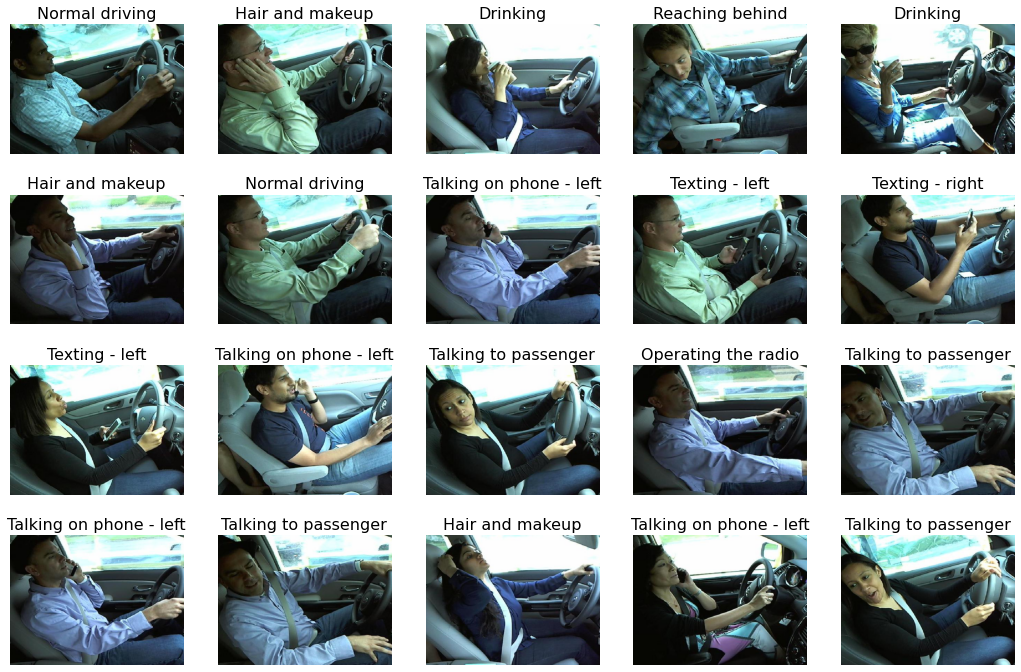

Training Image Stats
Image No: 0:  Min: 0.000, Max: 1.000, Mean: 0.330, Std: 0.308
Image No: 1:  Min: 0.000, Max: 1.000, Mean: 0.385, Std: 0.301
Image No: 2:  Min: 0.000, Max: 1.000, Mean: 0.456, Std: 0.342
Image No: 3:  Min: 0.000, Max: 1.000, Mean: 0.364, Std: 0.291
Image No: 4:  Min: 0.000, Max: 1.000, Mean: 0.437, Std: 0.358
Image No: 5:  Min: 0.000, Max: 1.000, Mean: 0.308, Std: 0.315
Image No: 6:  Min: 0.000, Max: 1.000, Mean: 0.356, Std: 0.294
Image No: 7:  Min: 0.000, Max: 1.000, Mean: 0.423, Std: 0.317
Image No: 8:  Min: 0.000, Max: 1.000, Mean: 0.386, Std: 0.313
Image No: 9:  Min: 0.000, Max: 1.000, Mean: 0.339, Std: 0.277
Image No: 10:  Min: 0.000, Max: 1.000, Mean: 0.377, Std: 0.340
Image No: 11:  Min: 0.000, Max: 1.000, Mean: 0.461, Std: 0.284
Image No: 12:  Min: 0.000, Max: 1.000, Mean: 0.366, Std: 0.342
Image No: 13:  Min: 0.000, Max: 1.000, Mean: 0.355, Std: 0.297
Image No: 14:  Min: 0.000, Max: 1.000, Mean: 0.414, Std: 0.314
Image No: 15:  Min: 0.000, Max: 1.000, Mean:

In [0]:
train_batches.reset()
imgs, titles = train_batches.next()
print("Training Image Sample")
plot_imgs(imgs, figsize=(18,12), rows=4, titles=titles, color_mode=color_mode)
print("Training Image Stats")
stats_imgs(imgs, titles=titles)

Training Image Sample


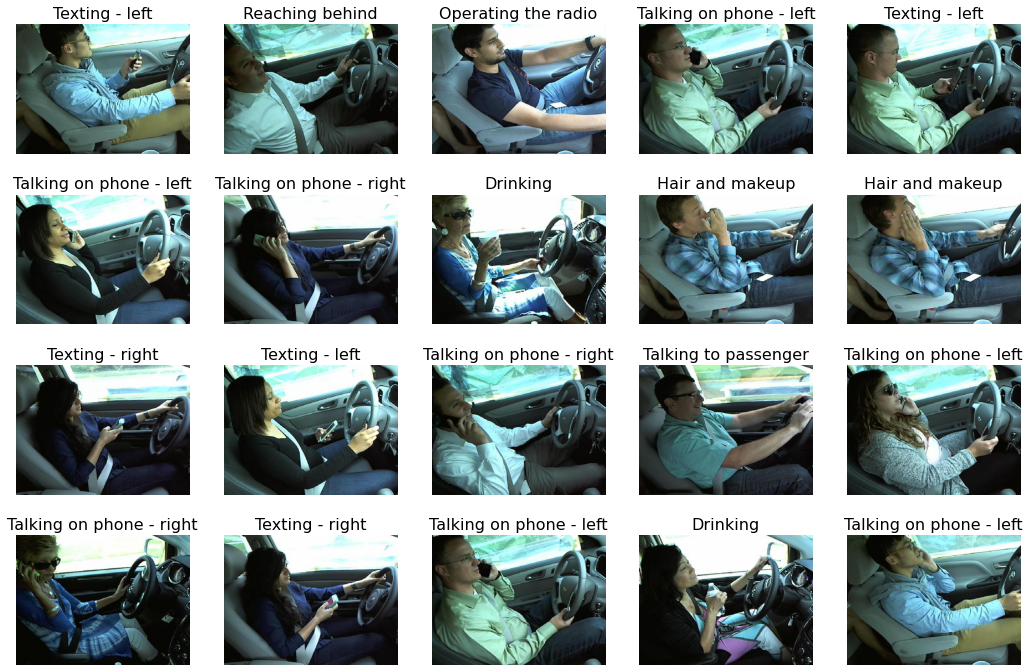

Training Image Stats
Image No: 0:  Min: 0.000, Max: 1.000, Mean: 0.410, Std: 0.280
Image No: 1:  Min: 0.000, Max: 1.000, Mean: 0.356, Std: 0.286
Image No: 2:  Min: 0.000, Max: 1.000, Mean: 0.438, Std: 0.286
Image No: 3:  Min: 0.000, Max: 1.000, Mean: 0.388, Std: 0.295
Image No: 4:  Min: 0.000, Max: 1.000, Mean: 0.400, Std: 0.319
Image No: 5:  Min: 0.000, Max: 1.000, Mean: 0.370, Std: 0.331
Image No: 6:  Min: 0.000, Max: 1.000, Mean: 0.350, Std: 0.353
Image No: 7:  Min: 0.000, Max: 1.000, Mean: 0.449, Std: 0.363
Image No: 8:  Min: 0.000, Max: 1.000, Mean: 0.407, Std: 0.279
Image No: 9:  Min: 0.000, Max: 1.000, Mean: 0.409, Std: 0.285
Image No: 10:  Min: 0.000, Max: 1.000, Mean: 0.305, Std: 0.325
Image No: 11:  Min: 0.000, Max: 1.000, Mean: 0.372, Std: 0.332
Image No: 12:  Min: 0.000, Max: 1.000, Mean: 0.386, Std: 0.303
Image No: 13:  Min: 0.000, Max: 1.000, Mean: 0.351, Std: 0.278
Image No: 14:  Min: 0.000, Max: 1.000, Mean: 0.374, Std: 0.307
Image No: 15:  Min: 0.000, Max: 1.000, Mean:

In [0]:
imgs, titles = train_batches.next()
print("Training Image Sample")
plot_imgs(imgs, figsize=(18,12), rows=4, titles=titles, color_mode=color_mode)
print("Training Image Stats")
stats_imgs(imgs, titles=titles)

### Make sure there is not a problem with augmented images; verify validation and train are both normalized, train images haven't cut out important features.  

#### First look at conservative augmentation parameters. 

In [0]:
batch_size = 20
epochs = 20
img_height = 224 
img_width = 224
color_mode = 'rgb'
color_channels = 3

In [0]:
train_datagen = ImageDataGenerator(
                                   rescale=1./255, 
                                   rotation_range=20,  
                                   height_shift_range=0.1, 
                                   width_shift_range=0.1,
                                   shear_range=10, 
                                   zoom_range=0.2, 
                                   fill_mode='nearest'
                                   )
val_datagen = ImageDataGenerator(
                                 rescale=1./255
                                 )

train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, val_datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


Training Image Sample


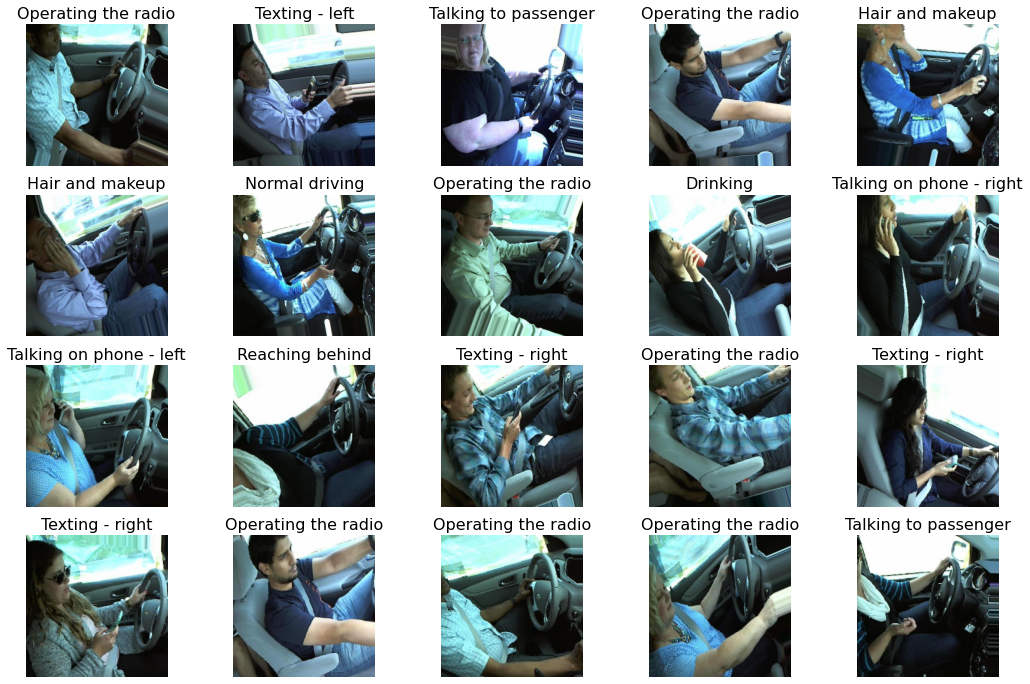

Training Image Stats
Image No: 0:  Min: 0.000, Max: 1.000, Mean: 0.337, Std: 0.286
Image No: 1:  Min: 0.000, Max: 1.000, Mean: 0.431, Std: 0.332
Image No: 2:  Min: 0.000, Max: 1.000, Mean: 0.470, Std: 0.366
Image No: 3:  Min: 0.000, Max: 1.000, Mean: 0.439, Std: 0.286
Image No: 4:  Min: 0.000, Max: 1.000, Mean: 0.394, Std: 0.338
Image No: 5:  Min: 0.000, Max: 1.000, Mean: 0.384, Std: 0.298
Image No: 6:  Min: 0.000, Max: 1.000, Mean: 0.378, Std: 0.338
Image No: 7:  Min: 0.000, Max: 1.000, Mean: 0.394, Std: 0.319
Image No: 8:  Min: 0.000, Max: 1.000, Mean: 0.425, Std: 0.348
Image No: 9:  Min: 0.000, Max: 1.000, Mean: 0.303, Std: 0.302
Image No: 10:  Min: 0.000, Max: 1.000, Mean: 0.442, Std: 0.307
Image No: 11:  Min: 0.000, Max: 1.000, Mean: 0.410, Std: 0.383
Image No: 12:  Min: 0.000, Max: 1.000, Mean: 0.345, Std: 0.253
Image No: 13:  Min: 0.000, Max: 1.000, Mean: 0.377, Std: 0.229
Image No: 14:  Min: 0.000, Max: 1.000, Mean: 0.440, Std: 0.357
Image No: 15:  Min: 0.000, Max: 1.000, Mean:

In [0]:
# Visualize augmented images, make sure they look ok. Check to make sure they are all normalized. Make sure image inconsistency is not source of validation accuracy issue. 
# First look at training images. 

imgs, titles = train_batches.next()
print("Training Image Sample")
plot_imgs(imgs, figsize=(18,12), rows=4, titles=titles, color_mode=color_mode)
print("Training Image Stats")
stats_imgs(imgs, titles=titles)

Validation Image Sample


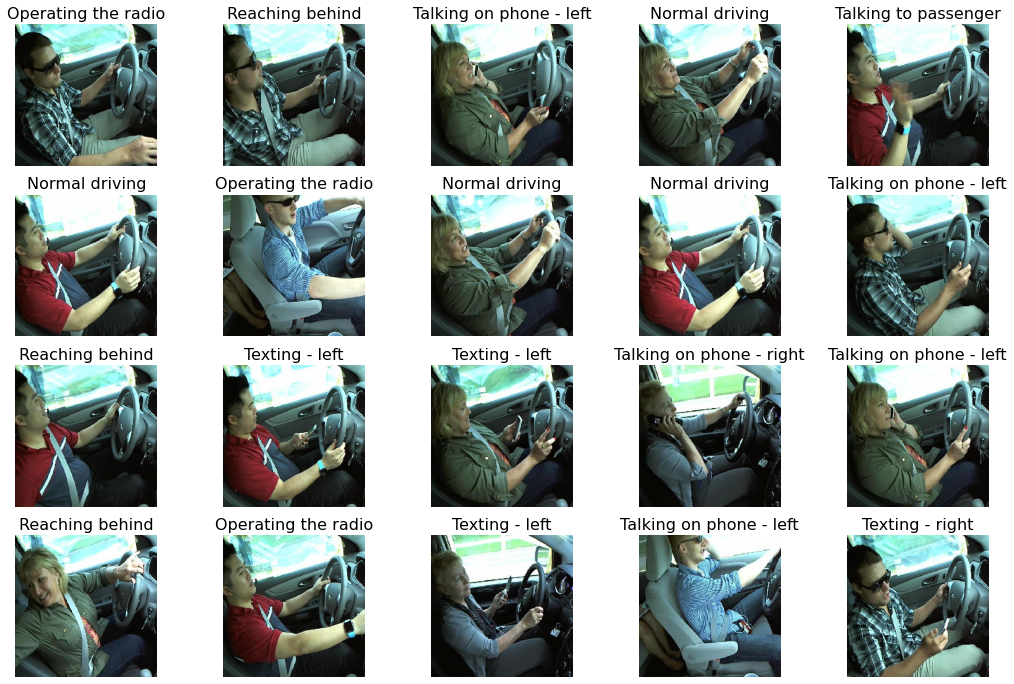

Validation Image Stats
Image No: 0:  Min: 0.000, Max: 1.000, Mean: 0.366, Std: 0.294
Image No: 1:  Min: 0.000, Max: 1.000, Mean: 0.390, Std: 0.299
Image No: 2:  Min: 0.000, Max: 1.000, Mean: 0.363, Std: 0.302
Image No: 3:  Min: 0.000, Max: 1.000, Mean: 0.373, Std: 0.314
Image No: 4:  Min: 0.000, Max: 1.000, Mean: 0.385, Std: 0.328
Image No: 5:  Min: 0.000, Max: 1.000, Mean: 0.428, Std: 0.341
Image No: 6:  Min: 0.000, Max: 1.000, Mean: 0.394, Std: 0.262
Image No: 7:  Min: 0.000, Max: 1.000, Mean: 0.372, Std: 0.312
Image No: 8:  Min: 0.000, Max: 1.000, Mean: 0.472, Std: 0.345
Image No: 9:  Min: 0.000, Max: 1.000, Mean: 0.379, Std: 0.301
Image No: 10:  Min: 0.000, Max: 1.000, Mean: 0.354, Std: 0.308
Image No: 11:  Min: 0.000, Max: 1.000, Mean: 0.381, Std: 0.333
Image No: 12:  Min: 0.000, Max: 1.000, Mean: 0.322, Std: 0.276
Image No: 13:  Min: 0.000, Max: 1.000, Mean: 0.337, Std: 0.328
Image No: 14:  Min: 0.000, Max: 1.000, Mean: 0.360, Std: 0.303
Image No: 15:  Min: 0.000, Max: 1.000, Mea

In [0]:
# Next look at validation images. 

imgs, titles = valid_batches.next()
print("Validation Image Sample")
plot_imgs(imgs, figsize=(18,12), rows=4, titles=titles, color_mode=color_mode)
print("Validation Image Stats")
stats_imgs(imgs, titles=titles)

### Now look at more aggressive augmentation parameters. 

In [0]:
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   height_shift_range=0.5,
                                   width_shift_range = 0.5,
                                   zoom_range = 0.5,
                                   rotation_range=30
                                   )
val_datagen = ImageDataGenerator(
                                 rescale=1./255
                                 )

train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, val_datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


Training Image Sample


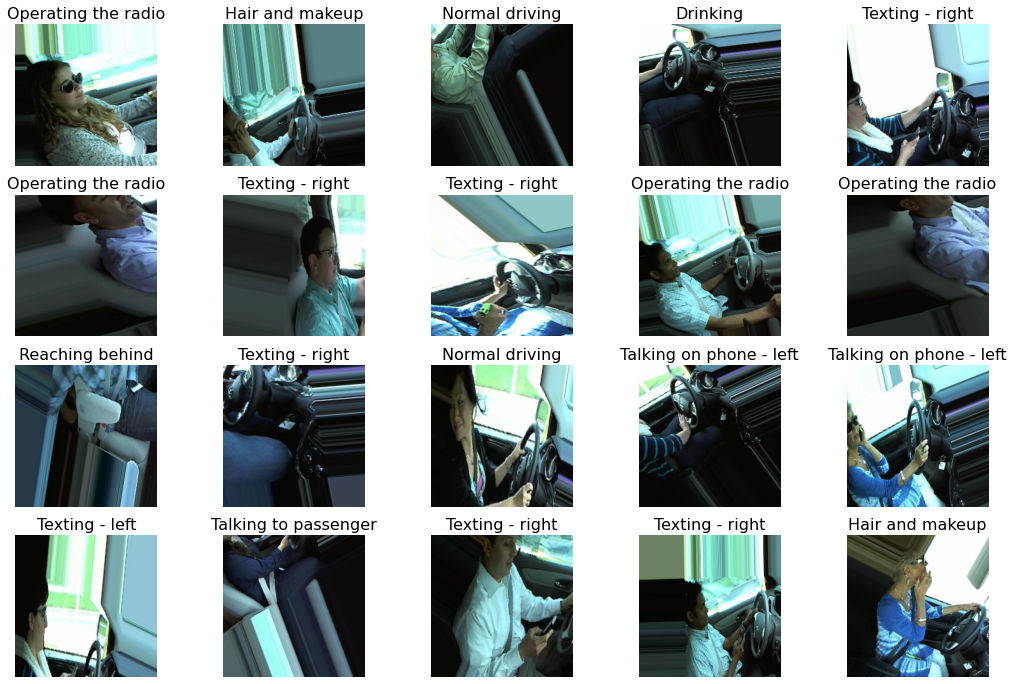

Training Image Stats
Image No: 0:  Min: 0.000, Max: 1.000, Mean: 0.499, Std: 0.357
Image No: 1:  Min: 0.000, Max: 1.000, Mean: 0.391, Std: 0.267
Image No: 2:  Min: 0.000, Max: 1.000, Mean: 0.167, Std: 0.185
Image No: 3:  Min: 0.000, Max: 1.000, Mean: 0.221, Std: 0.283
Image No: 4:  Min: 0.000, Max: 1.000, Mean: 0.610, Std: 0.388
Image No: 5:  Min: 0.000, Max: 1.000, Mean: 0.209, Std: 0.178
Image No: 6:  Min: 0.000, Max: 1.000, Mean: 0.312, Std: 0.263
Image No: 7:  Min: 0.000, Max: 1.000, Mean: 0.614, Std: 0.316
Image No: 8:  Min: 0.000, Max: 1.000, Mean: 0.430, Std: 0.333
Image No: 9:  Min: 0.000, Max: 1.000, Mean: 0.203, Std: 0.193
Image No: 10:  Min: 0.000, Max: 1.000, Mean: 0.268, Std: 0.193
Image No: 11:  Min: 0.000, Max: 1.000, Mean: 0.190, Std: 0.186
Image No: 12:  Min: 0.000, Max: 1.000, Mean: 0.419, Std: 0.372
Image No: 13:  Min: 0.000, Max: 1.000, Mean: 0.177, Std: 0.262
Image No: 14:  Min: 0.000, Max: 1.000, Mean: 0.462, Std: 0.363
Image No: 15:  Min: 0.000, Max: 1.000, Mean:

In [0]:
imgs, titles = train_batches.next()
print("Training Image Sample")
plot_imgs(imgs, figsize=(18,12), rows=4, titles=titles, color_mode=color_mode)
print("Training Image Stats")
stats_imgs(imgs, titles=titles)

#### This is clearly way too much augmentation.  
#### Let's try a middle ground. 

In [0]:
train_datagen = ImageDataGenerator(
                                   rescale=1./255, 
                                   rotation_range=30,  
                                   height_shift_range=0.2, 
                                   width_shift_range=0.2,
                                   shear_range=20, 
                                   zoom_range=0.2, 
                                   fill_mode='nearest'
                                   )
val_datagen = ImageDataGenerator(
                                 rescale=1./255
                                 )

train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, val_datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


Training Image Sample


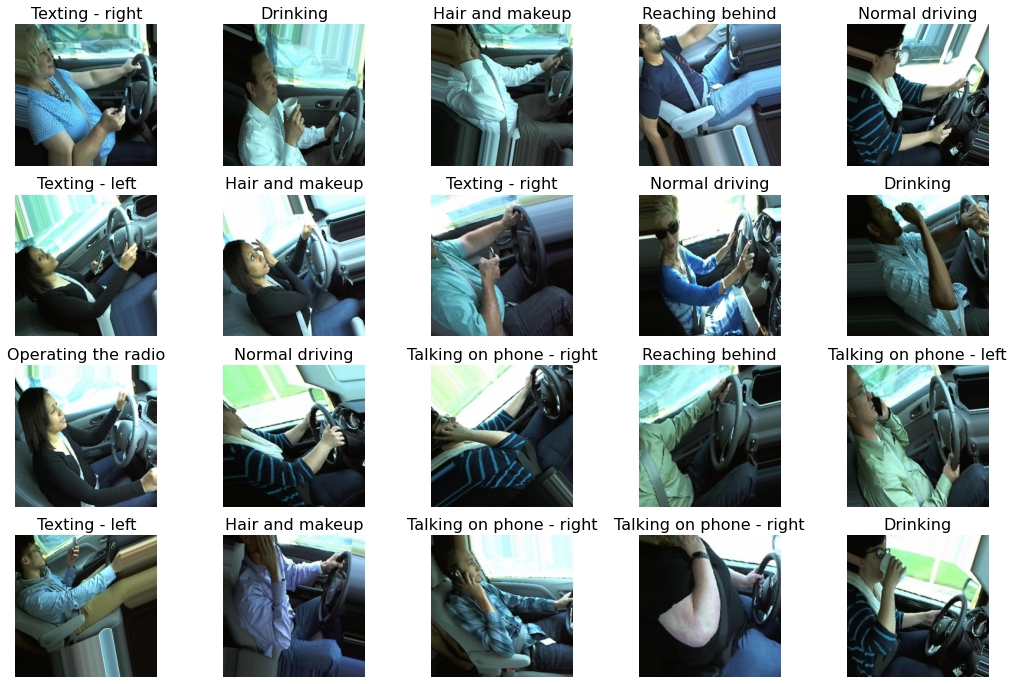

Training Image Stats
Image No: 0:  Min: 0.000, Max: 1.000, Mean: 0.385, Std: 0.268
Image No: 1:  Min: 0.000, Max: 1.000, Mean: 0.449, Std: 0.337
Image No: 2:  Min: 0.000, Max: 1.000, Mean: 0.375, Std: 0.291
Image No: 3:  Min: 0.000, Max: 1.000, Mean: 0.446, Std: 0.271
Image No: 4:  Min: 0.000, Max: 1.000, Mean: 0.362, Std: 0.341
Image No: 5:  Min: 0.000, Max: 1.000, Mean: 0.403, Std: 0.336
Image No: 6:  Min: 0.000, Max: 1.000, Mean: 0.482, Std: 0.361
Image No: 7:  Min: 0.000, Max: 1.000, Mean: 0.404, Std: 0.289
Image No: 8:  Min: 0.000, Max: 1.000, Mean: 0.410, Std: 0.347
Image No: 9:  Min: 0.000, Max: 1.000, Mean: 0.253, Std: 0.255
Image No: 10:  Min: 0.000, Max: 1.000, Mean: 0.422, Std: 0.356
Image No: 11:  Min: 0.000, Max: 1.000, Mean: 0.431, Std: 0.374
Image No: 12:  Min: 0.000, Max: 1.000, Mean: 0.367, Std: 0.363
Image No: 13:  Min: 0.000, Max: 1.000, Mean: 0.351, Std: 0.297
Image No: 14:  Min: 0.000, Max: 1.000, Mean: 0.387, Std: 0.284
Image No: 15:  Min: 0.000, Max: 1.000, Mean:

In [0]:
imgs, titles = train_batches.next()
print("Training Image Sample")
plot_imgs(imgs, figsize=(18,12), rows=4, titles=titles, color_mode=color_mode)
print("Training Image Stats")
stats_imgs(imgs, titles=titles)

#### Vertical shift is too much. 

In [0]:
train_datagen = ImageDataGenerator(
                                   rescale=1./255, 
                                   rotation_range=30,  
                                   height_shift_range=0.1, 
                                   width_shift_range=0.2,
                                   shear_range=20, 
                                   zoom_range=0.2, 
                                   fill_mode='nearest'
                                   )
val_datagen = ImageDataGenerator(
                                 rescale=1./255
                                 )

train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, val_datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


Training Image Sample


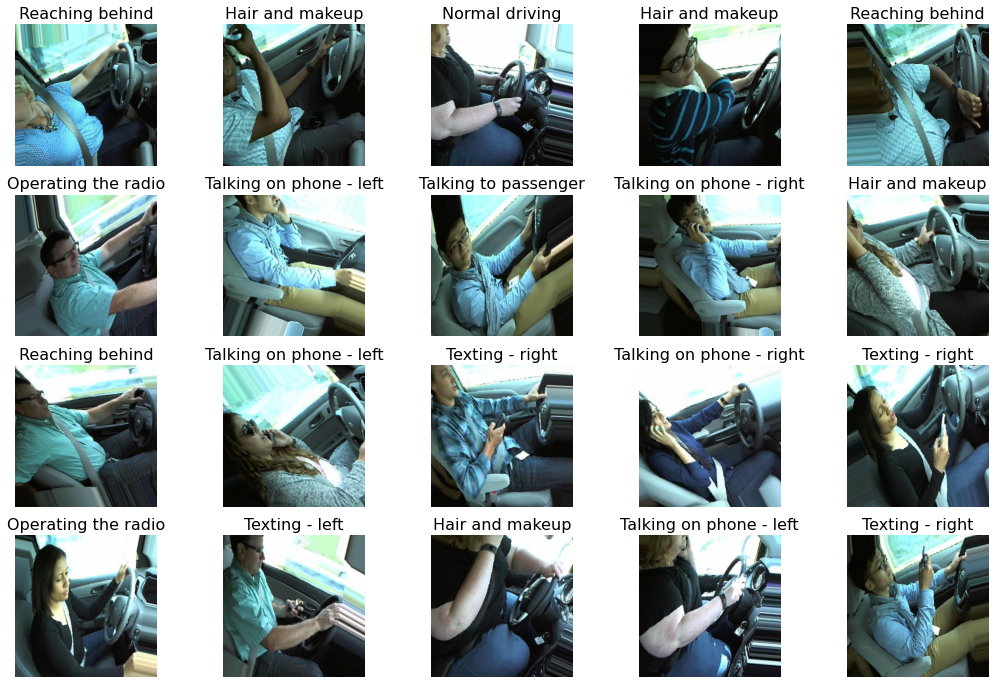

In [0]:
imgs, titles = train_batches.next()
print("Training Image Sample")
plot_imgs(imgs, figsize=(18,12), rows=4, titles=titles, color_mode=color_mode)

Training Image Sample


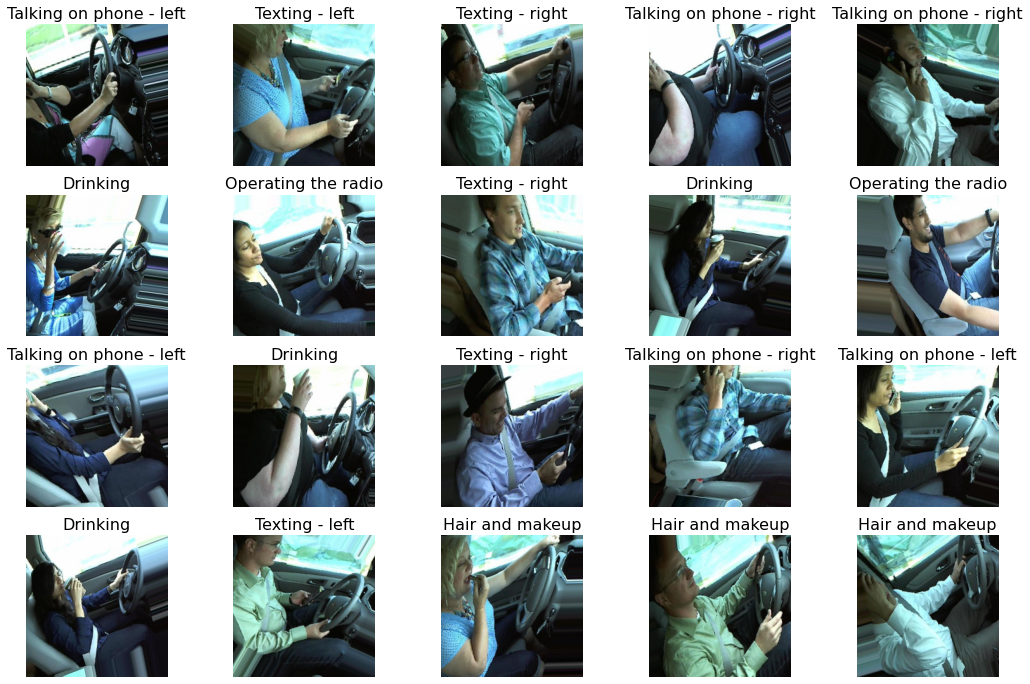

In [0]:
imgs, titles = train_batches.next()
print("Training Image Sample")
plot_imgs(imgs, figsize=(18,12), rows=4, titles=titles, color_mode=color_mode)

### This may be the most extreme we can do and not lose important data. 